In [102]:
import sys
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from sim_pipeline.galaxy_galaxy_lens_pop import GalaxyGalaxyLensPop
import lsst.daf.butler as dafButler
from sim_pipeline import lsst_science_pipeline
from sim_pipeline.image_simulation import rgb_image_from_image_list
from sim_pipeline.Util import param_util

## Lens injection in multiple DC2 cutout images

In this notebook, we will show how one can inject simulated lenses to multiple DC2 cutout images and

create a catalog of strong lense. and create a catalog of strong lense.

For this, we should follow following steps:
1. Create a lens population using sim-pipeline
2. Generate random ra and dec using random_ra_dec function in RSP module
3. Then, finally one can should call multiple_lens_injection function in RSP module

In [ ]:
## Users should change this path to their sim-pipeline path
sys.path.insert(0, "/home/nkhadka/notebooks/mytutorials/sim-pipeline/")

## Generate Galaxy-Galaxy Lens Population

In [360]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
sky_area = Quantity(value=0.1, unit="deg2")

# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 22, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 22, "z_min": 0.1, "z_max": 5.0}

# run skypy pipeline and make galaxy-galaxy population class using GalaxyGalaxyLensPop
gg_lens_pop = GalaxyGalaxyLensPop(
    deflector_type="all-galaxies",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=None,
    sky_area=sky_area,
    cosmo=cosmo,
)

## Initiate Butler
Butler is necessary to access and process DC2 data. So, one needs to initiate it. To initiate butler,

one needs to specify data configuration and data collection. Here we configure Rubin Observatory’s 

Data Preview 0.2 (dp02) . Data Preview 0 (dp0) is the first of three data previews during the period

leading up to the start of Rubin Observatory Operations. With the new release of dp0 data, one can 

use the new version in the future.Butler is necessary to access and process DC2 data. So, one needs 

to initiate it. To initiate butler, one needs to specify data configuration and data collection. 

Here we configure Rubin Observatory’s Data Preview 0.2 (dp02) . Data Preview 0 (dp0) is the first of 

three data previews during the period leading up to the start of Rubin Observatory Operations. With 

the new release of dp0 data, one can use the new version in the future.

In [338]:
config = "dp02"
collection = "2.2i/runs/DP0.2"
butler = dafButler.Butler(config, collections=collection)
skymap = butler.get("skyMap")

## Import lsst_science_pipeline module
This module can be used to do all the operation necessary for the lens injection in DC2 data.
We will choose 

100 random ra, dec pair in the DC2 data and we inject random gg lenses in these ra, dec position. 

Injected_lens_catalog contains following images and information,


1. Lens to be injected in r-band.
2. Corresponding DC2 cutout image in r-band.
3. r, g, and i band DC2 cutout images with corresponding injected lenes.
4. Center of the DC2 cutout images where lenses have been injected.

lsst_science_pipeline module is imported at the top

In [ ]:
##provide minimum and maximum limits for ra and dec. Also, specify how many ra, dec pair you want.
ra, dec = param_util.random_ra_dec(55, 70, -43, -30, 100)

In [ ]:
## specify pixel number and pixel scale of the images. Here we have chosen 64 and 0.2 respectively.
## We should choose pixel scale = 0.2 to match the pixel scale scale of DC2 data.
## For this function one lens_cut. If not provided, default option is None.
lens_cut = {
    "min_image_separation": 0.8,
    "max_image_separation": 10,
    "mag_arc_limit": {"g": 23, "r": 23, "i": 23},
}
injected_lens_catalog = lsst_science_pipeline.multiple_lens_injection(
    gg_lens_pop, 64, 0.2, ra, dec, butler, lens_cut=lens_cut, flux=None
)

In [ ]:
## This line should display an astropy table containg lens image,dp0 cutout_image, injected_lens
## in r, g, and i band and  center of the dp0 cutout images.
injected_lens_catalog

## Fast injection
The function multiple_lens_injection() is capable of injecting multiple lenses to the multiple dp0 cutout images. 

This function injects one lens per tract/patch ID. So, for each lens, it needs to query dp0 data. The time taken

by the lens injection process is mostly contributed by the dp0 data query. Therefore, it takes significantly 

large time to inject a given number of lenses to the dp0 cutouts. So, one can reduce the lens injection time by 

drawing multiple cutout images from the same tract/patch ID. This can be done by using the function 

multiple_lens_injection_fast() (see documentation for more detailed explanation).

In [398]:
## This line should display an astropy table containg lens image,dp0 cutout_image, injected_lens
## in r, g, and i band and  center of the dp0 cutout images
kwargs_lens_cut = {
    "min_image_separation": 0.8,
    "max_image_separation": 8,
    "mag_arc_limit": {"g": 23, "r": 23, "i": 23},
}
ra_2, dec_2 = param_util.random_ra_dec(55, 70, -43, -30, 10)
injected_lens_catalog_2 = lsst_science_pipeline.multiple_lens_injection_fast(
    gg_lens_pop, 64, 0.2, butler, ra_2, dec_2, 10, kwargs_lens_cut, flux=None
)
injected_lens_catalog_2

lens,cutout_image,injected_lens_r,injected_lens_g,injected_lens_i,cutout_center
"float64[64,64]","float32[64,64]","float64[64,64]","float64[64,64]","float64[64,64]",float64[2]
0.0008408614133014747 .. 0.0008329829571302478,0.038425904 .. -0.006250401,0.03926676518064881 .. -0.005417418070370382,0.002136620950730072 .. -0.004986935890550969,0.08871009795571243 .. 0.011381089581732982,66.78009171924977 .. -31.487782482169262
1.5373266702353727e-07 .. 1.0798089602461966e-07,0.015752502 .. 0.0019242468,0.01575265551842218 .. 0.0019243547633329915,-0.05643208403675516 .. -0.035874947688820345,-0.07009957596755666 .. -0.020158580499916236,66.97548699657962 .. -31.634342894823696
0.00014509201456941456 .. 0.00015416431336303694,-0.007368723 .. 0.0056893905,-0.007223630915981161 .. 0.005843554782705507,-0.004633541585210807 .. 0.008588253324029444,-0.042074711882695334 .. -0.015601672479091949,66.91119104734425 .. -31.586887423780006
0.0008258220173074666 .. 0.009317494034665835,0.013019378 .. 0.06584503,0.013845200314338392 .. 0.07516252160062195,0.042244134850374 .. -0.029827240165332253,0.06109153762549939 .. 0.14015457204530896,66.89457365922823 .. -31.506279075428807
0.00011665589441962887 .. 0.00015686122403702277,0.030289287 .. -0.02834657,0.030405942641994435 .. -0.028189708984631686,0.012568021895392386 .. -0.0013710034470890949,-0.0031880864418154142 .. 0.0034368882197653673,66.93181854790558 .. -31.567921880457792
8.008062182509462e-06 .. 2.535112805616968e-07,0.0031720449 .. 0.020464003,0.0031800529372827645 .. 0.02046425659737065,-0.006283596143732369 .. 0.024285029778619068,-0.007093498811447564 .. -0.04392432109946021,66.94706664357426 .. -31.469332139635384
6.052561545601132e-06 .. 5.531970156680277e-07,0.03598408 .. -0.037568115,0.03599013284637951 .. -0.03756756150091753,0.02224426630991971 .. 0.008608680912912822,0.03037742694135665 .. -0.10356135646102951,66.90813297207318 .. -31.463253979532805
0.14957270507366352 .. 0.13490983112618804,-0.009893581 .. -0.021916162,0.13967912380249195 .. 0.11299366890356422,0.09252293777176447 .. 0.08452485445668254,0.17385288192382276 .. 0.11772859176071648,66.82778291168381 .. -31.456409185137883
9.020006919852053e-08 .. 2.28813461122801e-07,-0.031901844 .. -0.036051046,-0.03190175364577507 .. -0.03605081728977794,0.0044721274694486 .. -0.024911790513184054,0.03918861761863495 .. 0.06926136673677269,66.9534988162672 .. -31.6133285383707


In [399]:
image_r = injected_lens_catalog_2['injected_lens_r']
image_g = injected_lens_catalog_2['injected_lens_g']
image_i = injected_lens_catalog_2['injected_lens_i']

In [400]:
rgb_image_list = []
for i in range(0, 100, 1):
    image_list = [image_i[i], image_r[i], image_g[i]]
    rgb_image_list.append(rgb_image_from_image_list(image_list, 0.5))

In [438]:
import random
def plot_montage_of_injected_lens(
        image_list,
        n_horizont=1,
        n_vertical=1):
        fig, axes = plt.subplots(
            n_vertical, n_horizont, figsize=(n_horizont * 3, n_vertical * 3)
        )
        for i in range(n_horizont):
            for j in range(n_vertical):
                ax = axes[j, i]
                index = random.randint(0, 99)
                image = image_list[index]
                ax.imshow(image, aspect="equal", origin="lower")
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                ax.autoscale(False)

        fig.tight_layout()
        fig.subplots_adjust(
            left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05
        )
        return None

(<Figure size 1500x900 with 15 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >]], dtype=object))

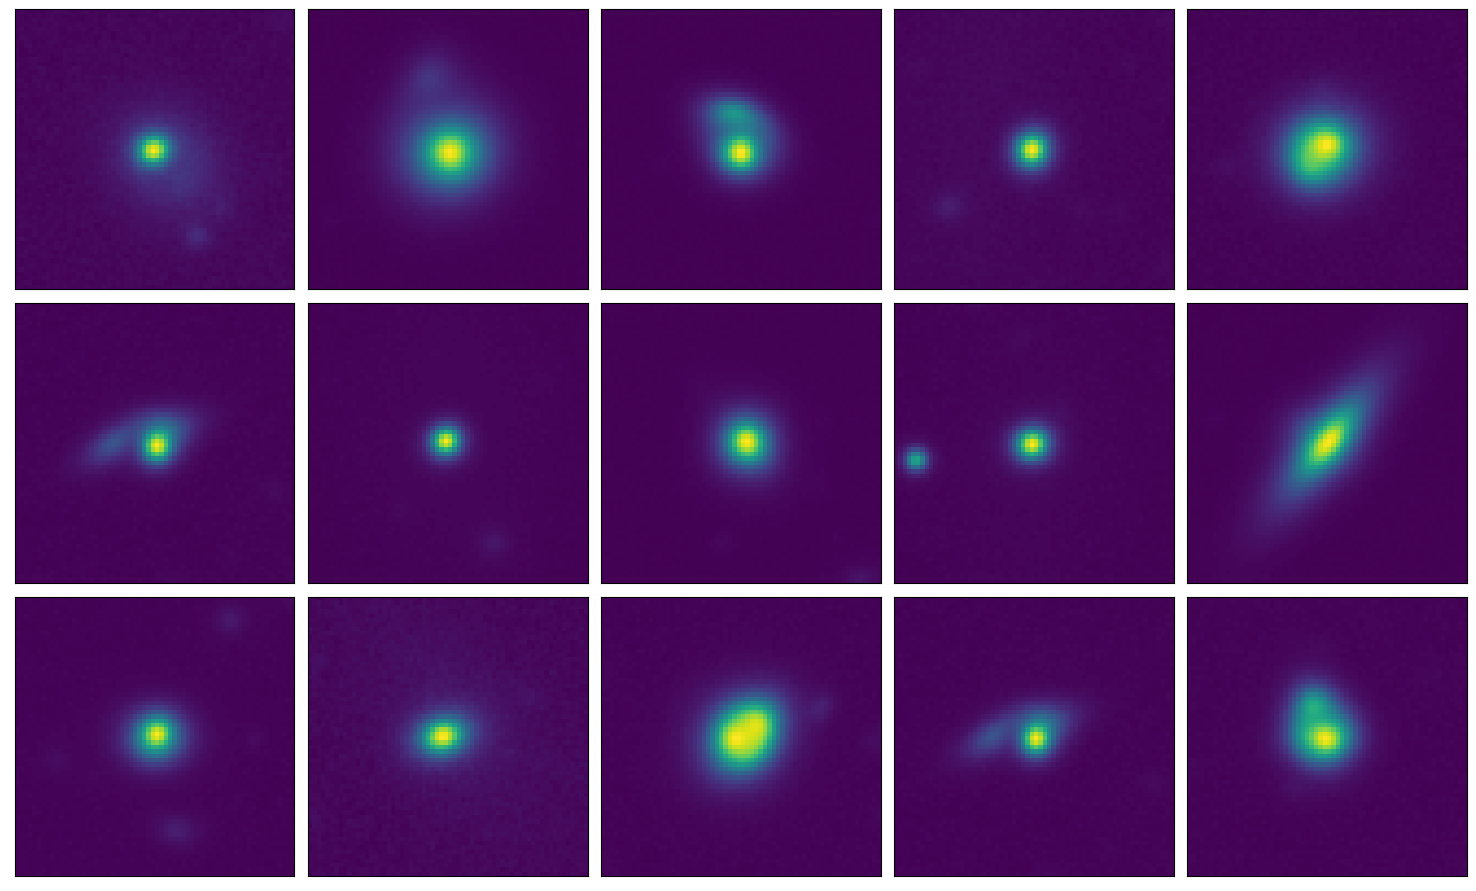

In [464]:
plot_montage_of_injected_lens(
        rgb_image_list,
        n_horizont=5,
        n_vertical=3)